Import libraries

In [91]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV # packages for hyperparameters tuning
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import os

import hopsworks

In [ ]:
project = hopsworks.login()

fs = project.get_feature_store()

In [50]:
# historical_features = pd.read_csv('data/historical_features.csv')

In [ ]:
news_propagation_fg = fs.get_feature_group(
    name="news_propagation",
    version=1,
)

In [ ]:
selected_features = news_propagation_fg.select_except(["news_id"])

In [ ]:
feature_view = fs.get_or_create_feature_view(
        name = 'news_propagation_feature_views',
        version = 1,
        labels=["label"],
        #transformation_functions=transformation_functions,
        query=selected_features,
)

In [ ]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

In [51]:
gossicop_fake_features_1 = pd.read_csv('data/gossipcop_fake_features_1.csv')
gossicop_fake_features_2 = pd.read_csv('data/gossipcop_fake_features_1_bis.csv')
political_features = pd.read_csv('data/politifact_features.csv')

In [52]:
historical_features = pd.concat([gossicop_fake_features_1, gossicop_fake_features_2, political_features])

In [53]:
historical_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 0 to 158
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   news_id                    254 non-null    object 
 1   average followers          254 non-null    float64
 2   average follows            254 non-null    float64
 3   repost total               254 non-null    int64  
 4   post total                 254 non-null    int64  
 5   repost percentage          254 non-null    float64
 6   average repost             254 non-null    float64
 7   average favorite           254 non-null    float64
 8   label                      254 non-null    int64  
 9   news lifetime              254 non-null    int64  
 10  nb users 10 hours          254 non-null    int64  
 11  average time difference    254 non-null    float64
 12  retweet percentage 1 hour  254 non-null    float64
dtypes: float64(7), int64(5), object(1)
memory usage: 27.8+ 

In [54]:
historical_features.groupby('label').size()

label
0    122
1    132
dtype: int64

In [55]:
X = historical_features.drop('label', axis=1)
X = X.drop("news_id", axis=1)
y = historical_features['label']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

In [58]:
dtrain.save_binary('train.buffer')
dtest.save_binary('test.buffer')
dval.save_binary('val.buffer')

In [59]:
param = {'max_depth': 3, 'eta': 1, 'objective': 'binary:logistic'}

In [60]:
num_round = 10
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [61]:
clf.save_model('0001.model')

c:\Users\celin_e3kjw6h\miniconda3\envs\fake_news\lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [62]:
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('model.bin')  # load model data

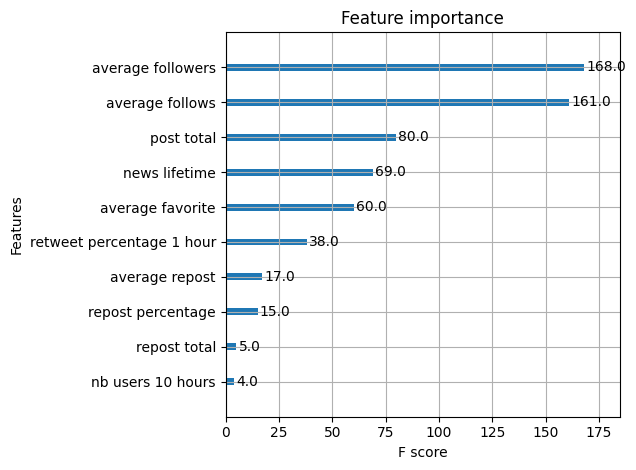

In [63]:
fig = xgb.plot_importance(clf)
fig.figure.tight_layout()
fig.figure.savefig('figures/feature_importance.png')

In [92]:
y_pred = clf.predict(X_test)

In [93]:
accuracy_score(y_test, y_pred)

0.5964912280701754

Hyperpameters tuning

In [90]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.5}
Best score:  0.7682539682539683


In [94]:
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.019308826060922404, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.5282940331158217}
Best score:  0.7625396825396826


In [ ]:
# Get the model registry
mr = project.get_model_registry()

In [ ]:
# Create input schema using X_train
input_schema = Schema(X_train)

# Create output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the model schema to a dictionary
model_schema.to_dict()# Specify the directory where the model files will be saved
model_dir = "news_propagation_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained classifier as json file
clf.save_model(model_dir + "/model.json")

In [ ]:
# Create a model in the model registry
model = mr.python.create_model(
    name="news_propagation_model",
    description="News Propagation Model",
    input_example=X_train.sample(),
    model_schema=model_schema,
)

# Save the model to the specified directory
model.save(model_dir)